In [2]:
""" import useful functions """

# Generic
import pandas as pd
import numpy as np
import scipy
import sys
from itertools import islice, cycle
import math
import os
import sys
from scipy.integrate import odeint

# cosmology
import pyccl as ccl
import tjpcov as tjp
from tjpcov.covariance_calculator import CovarianceCalculator
from astropy.io import fits
import yaml
import sacc
import time

# Generate data sets
from sklearn.datasets import make_blobs

# PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# nDGP NL and lin Pk
from nDGPemu import BoostPredictor
MODULE_PATH = "/home/c2042999/MGCAMB/camb/__init__.py"
MODULE_NAME = "MGCAMB"
import importlib
spec = importlib.util.spec_from_file_location(MODULE_NAME, MODULE_PATH)
module = importlib.util.module_from_spec(spec)
sys.modules[spec.name] = module 
spec.loader.exec_module(module)
from MGCAMB import camb

# 1. Create mock redshift distribution (define z and output Binned_distribution(z))

In [3]:
""" Get a binned redshift distribution - defining functions """
"""This will come from the dataset we decide to test"""

# define the reasonable redshift distribution (not normalized yet)

def redshiftdist(z):
    """
    Defines a reasonable redshift distribution (not normalized yet)
    input:
        redshift z: numpy.array with dim:N
    returns:
        redshift distribution p(z): numpy.array with dim:N
    """
    alpha = 1.27
    beta = 1.02
    z0 = 0.3
    pz = z**alpha * np.exp(-(z / z0)**beta)
    return pz

def bindist(z, n_bins):
    """
    Finds redshift bins so that integral of p(z) over each bin stays the same.
    (in limit of large len(z))
    input:
        redshift z: numpy.array with dim:N
        number of bins n_bins: int (value M)
    returns:
        redshift bin edges: numpy.array with dim:M+1
    """
    # have redshiftdist(z), z 
    # find bins: integrate between 0 and i redshift(z)
    #            if integral => 1/n_bin, that is a bin
    #            repeat for 2/n_bin, 3/n_bin, etc
    pz = redshiftdist(z)
    N = scipy.integrate.simps(pz, z)                                      # Normalization factor
    pz = pz/N                                                             # Normalize p(z)
    j = 1
    bins = np.zeros(int(n_bins + 1))
    for i in range(len(z) - 10):
        I = scipy.integrate.simps(pz[0 : i + 10], z[0 : i + 10])
        if I >= j / n_bins:
            bins[j] = z[i + 10]
            j += 1
    bins[int(n_bins)] = z[len(z) - 1]
    bins[0] = z[0]
    return bins

def gaussianphotoz(zs , zp):
    """
    Finds gaussian photo-z uncertainties
    """
    I = np.exp(-np.power(zs - zp , 2.) / (2 * np.power(0.05 * (1 + zp) , 2.)))
    N = scipy.integrate.simps(I , zs)
    return I/(N)

def binning_redshiftdist(z , n_bins):
    """
    bins distribution for p(z) in n_bins with same number of galaxies in each bin, 
    smoothened by gaussianphotoz(zs , zp) kernel
    input:
        redshift z: numpy.array with dim:N
        number of bins n_bins: int of size M
    returns:
        binned redshift distribution: numpy.array with dim:(N,M)
        sum: p(z) recovered by summing over all binned redshift distributions: numpy.array with dim:N
    """
    N = scipy.integrate.simps(redshiftdist(z), z)

    # complete binning
    bin_edges = bindist(z, n_bins)

    # smoothing redshift distribution with gaussian kernel
    Sum = 0                                                                       # find what the sum of normalized plots is. Want this equal to Rdist
    binned_redshiftdist = np.zeros((len(bin_edges) - 1, len(z)))

    for i in range(len(bin_edges) - 1):
        Rdist_new = np.zeros(len(z))
        conv = np.zeros(len(z))

        for j in range(len(z)):                                                  # define binned redshift functions before smoothing
            if z[j] >= bin_edges[i] and z[j] <= bin_edges[i+1]:
                Rdist_new[j] = redshiftdist(z[j])/(N)
    
        for j in range(len(z)):                                                  # smoothen distributions by convolving with a gaussian kernel
            conv[j] = scipy.integrate.simps(Rdist_new * gaussianphotoz(z , z[j]) , z)
    
        binned_redshiftdist[i] = conv
    
        Sum += conv
    
    #plt.plot(zp, conv)
    return binned_redshiftdist , Sum

In [4]:
""" Get a binned redshift distribution - getting the actual distribution """

# find normalized redshift distribution

z = np.linspace(0.001 , 2.0 , int(1e2))

Rdist = redshiftdist(z)
N = scipy.integrate.simps(Rdist, z)                                    # Normalization factor
Rdist = Rdist/N

Binned_distribution = binning_redshiftdist(z , 5)[0]

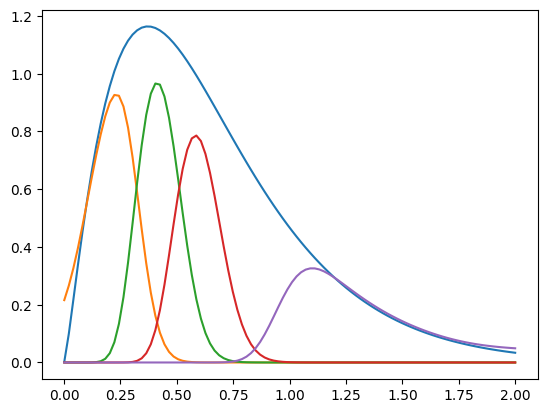

In [5]:
## TEST2: Plots to check binned redshift distribution


plt.plot(z , Rdist)
plt.plot(z ,Binned_distribution[0])
plt.plot(z ,Binned_distribution[1])
plt.plot(z ,Binned_distribution[2])
plt.plot(z ,Binned_distribution[len(Binned_distribution)-1])


# 2. Define functions for training data (P(k)) from Emulators

The power spectrum in $\Lambda$CDM and nDGP is the same in the early universe (i.e. $\approx z=49$). This means we have:

$P_{\delta}(z=49) = \Big(\frac{\delta^{\Lambda CDM}(z=49)}{\delta^{\Lambda CDM}(z=0)}\Big)^2P^{\Lambda CDM}_{\delta}(z=0) = \Big(\frac{\delta^{nDGP}(z=49)}{\delta^{nDGP}(z=z_{ini})}\Big)^2P^{nDGP}_{\delta}(z=z_{ini})$

Therefore 

$P^{nDGP}_{\delta}(z=z_{ini}) = \Big(\frac{D_+^{\Lambda CDM}(z=49)}{D_+^{nDGP}(z=49)} \times \frac{D_+^{nDGP}(z=z_{ini})}{D_+^{\Lambda CDM}(z=z_{ini})}
\Big)^2P^{\Lambda CDM}_{\delta}(z=0)$

where $D_+(z=0) = 1$.

In [6]:
""" define useful functions"""

# NL matter power spectra in nDGP
def P_k_NL_nDGP(cosmo, MGparams, k, a):
    """
    input k (array) -> wavevector, units 1/Mpc
    input a (float) -> scale factor (1/(1+z))
    input cosmo (cosmology object) -> Cosmology object from CCL
    input MGparams (array) -> Modified gravity parameters ([Omega_rc, fR0, n))
    
    output Pk_nDGP (array) -> Nonlinear matter power spectrum for nDGP gravity, units (Mpc)^3
    """
    # Turn k into units of h/Mpc
    k = k/cosmo["h"]

    Omega_rc, fR0, n = MGparams

    # nDGP emulator - get boost
    cosmo_params = {'Om':cosmo["Omega_m"],
                    'ns':cosmo["n_s"],
                    'As':cosmo["A_s"],
                    'h':cosmo["h"],
                    'Ob':cosmo["Omega_b"]}
    pkratio_nDGP = model_nDGP.predict(1/np.sqrt(4*Omega_rc), 1/a -1 , cosmo_params, k_out=k)

    # Get GR power spectrum
    
    Pk_ccl = ccl.power.nonlin_power(cosmo, k*cosmo["h"], a=a) # units (Mpc)^3
    return pkratio_nDGP*Pk_ccl

# TOCHANGE: NL matter power spectra in fR
def P_k_NL_fR(cosmo, MGparams, k, a):
    """
    input k (array) -> wavevector, units 1/Mpc
    input a (float) -> scale factor (1/(1+z))
    input cosmo (cosmology object) -> Cosmology object from CCL
    input MGparams (array) -> Modified gravity parameters ([Omega_rc, fR0, n))
    
    output Pk_fR (array) -> Nonlinear matter power spectrum for Hu-Sawicki fR gravity, units (Mpc)^3
    """
    # Turn k into units of h/Mpc
    k = k/cosmo["h"]

    Omega_rc, fR0, n = MGparams

    # nDGP emulator - get boost
    cosmo_params = {'Om':cosmo["Omega_m"],
                    'ns':cosmo["n_s"],
                    'As':cosmo["A_s"],
                    'h':cosmo["h"],
                    'Ob':cosmo["Omega_b"]}
    
    # fR emulator - get boost
    ## WILL HAVE TO CHANGE: for now same as nDGP but different MG param
    pkratio_fR = model_nDGP.predict(1/np.sqrt(4*Omega_rc), 1/a -1 , cosmo_params, k_out=k)

    # Get GR power spectrum
    
    Pk_ccl = ccl.power.nonlin_power(cosmo, k*cosmo["h"], a=a) # units (Mpc)^3
    return pkratio_fR*Pk_ccl

"""Functions for linear Pk"""

# dimensionless hubble parameter in GR
def E(cosmo, a):
    Omg_r = cosmo["Omega_g"]*(1+ 3.046*7/8 * (4/11)**(7/8))
    return np.sqrt(cosmo["Omega_m"]/a**3 +Omg_r/a**4 + (1 - cosmo["Omega_m"] - Omg_r))

# deriv. of E wrt scale factor, GR
def dEda(cosmo, a):
    Omg_r = cosmo["Omega_g"]*(1+ 3.046*7/8 * (4/11)**(7/8))
    E_val = E(cosmo, a)
    
    return (-3*cosmo["Omega_m"]/a**4 -4*Omg_r/a**5)/2/E_val

# mu(k,a) = mu(a) in nDGP (modified gravity parametrization parameter)
def mu_nDGP(Omg_rc, cosmo, a):
    if Omg_rc == 0:
        return 1
    else:
        E_val = E(cosmo, a)
        beta = 1 + E_val/np.sqrt(Omg_rc) * (1+ a*dEda(cosmo, a)/3/E_val)
        return 1 + 1/3/beta
    
def solverGrowth(y,a,cosmo, Omg_rc):
    E_val = E(cosmo, a)
    D , a3EdDda = y
    
    ydot = [a3EdDda / (E_val*a**3), 3*cosmo["Omega_m"]*D*(mu_nDGP(Omg_rc, cosmo, a))/(2*E_val*a**2)]
    return ydot
    
def P_k_nDGP_lin(cosmo, MGparams, k, a):
    """
    input k (array) -> wavevector, units 1/Mpc
    input a (float) -> scale factor (1/(1+z))
    input cosmo (cosmology object) -> Cosmology object from CCL
    input MGparams (array) -> Modified gravity parameters ([Omega_rc, fR0, n))
    
    output Pk_nDGP (array) -> linear matter power spectrum for nDGP gravity, units (Mpc)^3
    """
    # Turn k into units of h/Mpc
    k = k/cosmo["h"]
    
    # Get growth factor in nDGP and GR
    Omega_rc, fR0, n = MGparams
    a_solver = np.linspace(1/50,1,100)
    Soln = odeint(solverGrowth, [a_solver[0], (E(cosmo, a_solver[0])*a_solver[0]**3)], a_solver, \
                  args=(cosmo,Omega_rc), mxstep=int(1e4))
    
    Delta = Soln.T[0]/Soln.T[0][-1]
    Soln = odeint(solverGrowth, [a_solver[0], (E(cosmo, a_solver[0])*a_solver[0]**3)], a_solver,\
                  args=(cosmo,0), mxstep=int(1e4))
    
    Delta_GR = Soln.T[0]/Soln.T[0][-1]

    # Get Pk linear in GR
    pars.set_matter_power(redshifts=[1/a - 1], kmax=12.0)
    pars.set_cosmology(H0=cosmo["h"]*100, ombh2=cosmo["h"]**2*cosmo["Omega_b"], omch2=cosmo["h"]**2*cosmo["Omega_c"], omk=0, mnu=0.0)
    pars.InitPower.set_params(ns=cosmo["n_s"], As = cosmo["A_s"])
    pars.set_mgparams(MG_flag = 0)
    pars.NonLinear = camb.model.NonLinear_none
    results = camb.get_results(pars)
    kh, z, pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=10.0, npoints = 213) # pk units (Mpc/h)^3

    Pk_GR = np.interp(k, kh, pk[0])

    Delta_nDGP_49 = Delta[0]
    Delta_GR_49 = Delta_GR[0]
    return Pk_GR * (Delta_GR_49 / Delta_nDGP_49) **2  / cosmo["h"]**3  # units (Mpc)^3


## WILL HAVE TO CHANGE: for now same as nDGP but different MG param
def P_k_fR_lin(cosmo, MGparams, k, a):
    return P_k_nDGP_lin(cosmo, MGparams, k, a)


In [7]:
"""Initialize some things (e.g. emulators and MGCAMB)"""
# Load the nDGP emulator
model_nDGP = BoostPredictor()

# Initialize MGCAMB
pars = camb.CAMBparams()


Loading model and related data


/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator MLPRegressor from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## 2.a. Test functions for P(k)

(58,)
(12, 58)
(12, 58)


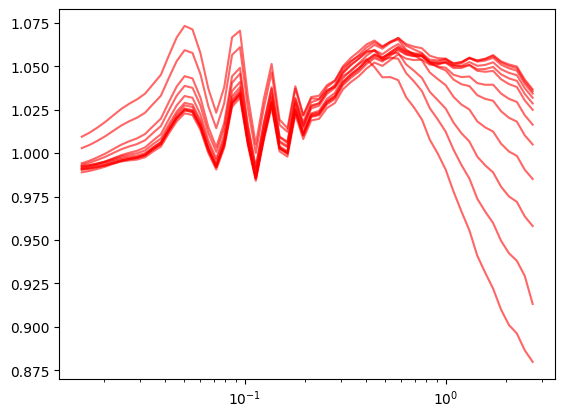

In [11]:
"""Load ReACT pre-made plots"""

# nDGP
arr = np.loadtxt("/home/c2042999/REACT_inst2/Lin_NL_nDGP_pk.txt")

# Cosmo and MG parameters same as in ReACT
H0rc_arr = np.logspace(np.log10(0.2),np.log10(20)-0.001,12)
cosmo = ccl.Cosmology(Omega_c = (0.1417493400784 - 0.0223)/0.67**2,
                           Omega_b =  0.0223/0.67**2,
                           h = 0.67,
                           n_s = 0.9665,
                           A_s = 2.01e-9)

k_ReACT = arr[0][60:-10] * cosmo["h"] # 1/Mpc
print(k_ReACT.shape)
pofk_lin_MG_react = arr[13:][:,60:-10] / cosmo["h"]**3 # Mpc^3
print(pofk_lin_MG_react.shape)
pofk_NL_MG_react = arr[1:13][:,60:-10]  / cosmo["h"]**3 # Mpc^3
print(pofk_NL_MG_react.shape)


for i in range(len(H0rc_arr)):
    Pk_nDGP_NL_test = P_k_NL_nDGP(cosmo, [1/(4*H0rc_arr[i]**2),0,0], k_ReACT, 1)
    Pk_nDGP_lin_test = P_k_nDGP_lin(cosmo, [1/(4*H0rc_arr[i]**2),0,0], k_ReACT, 1)
    plt.semilogx(k_ReACT, (Pk_nDGP_NL_test/Pk_nDGP_lin_test) / (pofk_NL_MG_react[i]/pofk_lin_MG_react[i]), "r", alpha=0.6)

## Function for angular power spectrum (lensing-lensing) (C_ell) from a given P_del(k, a) = pk_func(k, a)

In [8]:
def Cell(ell_min, ell_max, ell_bin_num, cosmo, z, Binned_distribution, pk_F, MGParams):
    """
    Finds C^{i,j}(ell) for {i,j} redshift bins (shape-shape angular power spectrum).
    input:
        redshift z: numpy.array with dim:N
        binned redshift dist: numpy.array with dim:(N,M) (M = no. z bins)
        minimum value of ell: int
        maximum value of ell: int
        number of ell bins: int (value P)
        pk_F: function (cosmo, MGParams, k,a) for k (in 1/Mpc), returns matter power spectrum (in Mpc^3)
    returns:
        ell bins: numpy.array with dim:P*(M+1)*M/2
        C_ell: numpy.array with dim:P*(M+1)*M/2
    """
    #find ell array
    ell = np.arange(ell_min, ell_max)
    
    # define quantities for binning in ell
    ell_binned_limits = np.logspace(np.log10(ell_min),np.log10(ell_max),num=ell_bin_num + 1)
    bin_edge1 = ell_binned_limits[:-1]
    bin_edge2 = ell_binned_limits[1:]
    ell_binned = (bin_edge1 + bin_edge2) / 2
    # Repeat ell_binned over all redshift bins, so that len(ell_binned)=len(C_ell_array)
    ell_binned = list(islice(cycle(ell_binned), int(ell_bin_num*((len(Binned_distribution)+1)*len(Binned_distribution))/2)))
    
    # Find NL power spectrum at given cosmo
    logk = np.linspace(-1.8,0.5,100)
    a_arr = np.flip(1/(1+z))
    pk_arr = np.zeros((len(a_arr),len(logk)))
    for i in range(len(a_arr)):
        pk_arr[i] = pk_F(cosmo, MGParams,10**logk,a_arr[i])
        
    P_delta2D = ccl.pk2d.Pk2D(a_arr=a_arr, lk_arr=logk, pk_arr=pk_arr)
    
    #P_delta2D = ccl.pk2d.Pk2D.from_function(pkfunc=pk_func, is_logp=False)

    C_ell_array = []
    for j in range(len(Binned_distribution)):
        for k in range(len(Binned_distribution)):
            if k > j:
                break
            
            tracer1 = ccl.WeakLensingTracer(cosmo, dndz=(z, Binned_distribution[j]))
            tracer2 = ccl.WeakLensingTracer(cosmo, dndz=(z, Binned_distribution[k]))
            
            C_ell = ccl.angular_cl(cosmo, tracer1, tracer2, ell)#, p_of_k_a=P_delta2D)
            """
            # bin ell
            bin_means, bin_edges, binnumber = scipy.stats.binned_statistic(ell, C_ell, statistic='mean', 
                                                                           bins= ell_binned_limits)
            C_ell_array = np.append(C_ell_array, bin_means)
            """
    return ell_binned, C_ell_array

In [16]:
logk = np.linspace(-1.8,0.5,100)
a_arr = np.flip(1/(1+z))
pk_arr = np.zeros((len(a_arr),len(logk)))
for i in range(len(a_arr)):
    pk_arr[i] = P_k_NL_nDGP(cosmo, MGParams,10**logk,a_arr[i])
    
P_delta2D = ccl.pk2d.Pk2D(a_arr=a_arr, lk_arr=logk, pk_arr=pk_arr)
    

In [ ]:
tracer1 = ccl.WeakLensingTracer(cosmo, dndz=(z, Binned_distribution[0]))
tracer2 = ccl.WeakLensingTracer(cosmo, dndz=(z, Binned_distribution[0]))
            
C_ell = ccl.angular_cl(cosmo, tracer1, tracer2, ell = np.arange(2,2060), p_of_k_a=P_delta2D)

In [9]:
"""Create mock data vector"""

# define ell and C_ell shapes -- will depend on the data

ell_min_mockdata = 2
ell_max_mockdata = 2060

# define quantities for binning of ell -- will depend on the data

ell_bin_num_mockdata = 18

# Define cosmology -- our "universe cosmology"

cosmo_universe = ccl.Cosmology(Omega_c = 0.26, 
                          Omega_b = 0.05, 
                          h = 0.7, 
                          n_s = 0.96,
                          A_s = 2.01e-9)

MGParams = [1.0 , 1.0, 1]

# find C_ell for non-linear matter power spectrum
mockdata = Cell(ell_min_mockdata, ell_max_mockdata, ell_bin_num_mockdata, \
                cosmo_universe, z , Binned_distribution, P_k_NL_nDGP, MGParams)

ell_mockdata = mockdata[0]
D_mockdata = mockdata[1]

del mockdata

/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/pyccl/tracers.py:151: CCLWarning: The number of samples in the n(z) (100) is smaller than the number of samples in the lensing kernel (256). Consider disabling spline integration for the lensing kernel by setting pyccl.gsl_params.LENSING_KERNEL_SPLINE_INTEGRATION = False before instantiating the Cosmology passed.
  warnings.warn(


## Get quantities to put in MCMC step

In [66]:
"""Package quanitites to imput into likelihood function"""
P_k_sim_mock = [pk_lin, pk_nl, k_traindata, a_traindata]
C_ell_data_mock = [D_mockdata, ell_mockdata, z, Binned_distribution]

"""Define MCMC step"""
cosmo_MCMC = ccl.Cosmology(Omega_c = 0.25, 
                      Omega_b = 0.05,
                      h = 0.7,
                      n_s = 0.95,
                      sigma8 = 0.8,
                      matter_power_spectrum='linear')

## Define functions for MCMC

In [67]:
def findC_ell_array(cosmoMCMCstep, C_ell_data , P_k_sim):
    """
    Find C_ell_training nonlinear for a single MCMC step for the training power spectra
    Pk_nl or _lin: (no training sims, a_arr, k_arr)
    """
    pk_lin, pk_nl, k_arr, a_arr = P_k_sim
    D_datavect, ell_binned, z, Binned_distribution = C_ell_data

    # Define quantities for ell binning
    ell_bin_num = int(len(ell_binned)/((len(Binned_distribution)+1)*len(Binned_distribution)/2))
    ell = ell_binned[0:ell_bin_num]
    
    B_data = np.zeros((len(pk_lin),len(D_datavect)))

    for i in range(len(pk_nl)):
        C_ell_array = []

        # Find P(k) at cosmo of specific MCMC step
        pk_fid = ccl.linear_matter_power(cosmoMCMCstep, k=k_arr, a=a_arr)
        P_delta = (pk_nl[i]/pk_lin[i]) * pk_fid
        P_delta2D = ccl.pk2d.Pk2D(a_arr=a_arr, lk_arr=np.log(k_arr), pk_arr=P_delta, is_logp=False)
        
        for j in range(len(Binned_distribution)):
            for k in range(len(Binned_distribution)):
                if k > j:
                    break
                tracer1 = ccl.WeakLensingTracer(cosmoMCMCstep, dndz=(z, Binned_distribution[j]))
                tracer2 = ccl.WeakLensingTracer(cosmoMCMCstep, dndz=(z, Binned_distribution[k]))
                C_ell = ccl.angular_cl(cosmoMCMCstep, tracer1, tracer2, ell, p_of_k_a=P_delta2D)        # uses non-linear matter power spectrum stored in `cosmo`

                C_ell_array = np.append(C_ell_array, C_ell)
        B_data[i] = C_ell_array
    return ell_binned, B_data

In [68]:
def findC_ell_array_linear(cosmoMCMCstep, C_ell_data , P_k_sim):
    """
    Find C_ell_training linear for a single MCMC step for the training power spectra
    Pk_nl or _lin: (no training sims, a_arr, k_arr)
    """
    pk_lin, pk_nl, k_arr, a_arr = P_k_sim
    D_datavect, ell_binned, z, Binned_distribution = C_ell_data

    # Define quantities for ell binning
    ell_bin_num = int(len(ell_binned)/((len(Binned_distribution)+1)*len(Binned_distribution)/2))
    ell = ell_binned[0:int(ell_bin_num)]
    
    B_data = np.zeros((len(pk_lin),len(D_datavect)))

    for i in range(len(pk_nl)):
        C_ell_array = []
        
        P_delta = ccl.linear_matter_power(cosmoMCMCstep, k=k_arr, a=a_arr)
        P_delta2D = ccl.pk2d.Pk2D(a_arr=a_arr, lk_arr=np.log(k_arr), pk_arr=P_delta, is_logp=False)
        
        for j in range(len(Binned_distribution)):
            for k in range(len(Binned_distribution)):
                if k > j:
                    break
                tracer1 = ccl.WeakLensingTracer(cosmoMCMCstep, dndz=(z, Binned_distribution[j]))
                tracer2 = ccl.WeakLensingTracer(cosmoMCMCstep, dndz=(z, Binned_distribution[k]))
                C_ell = ccl.angular_cl(cosmoMCMCstep, tracer1, tracer2, ell, p_of_k_a=P_delta2D)

                C_ell_array = np.append(C_ell_array, C_ell)
        B_data[i] = C_ell_array
    return ell_binned, B_data

In [69]:
## TEST: FIND M, B_data for example MCMC step
C_ell_data = findC_ell_array(cosmo_MCMC, C_ell_data_mock , P_k_sim_mock)

ell = C_ell_data[0]
B_data = C_ell_data[1]

C_ell_data_lin = findC_ell_array_linear(cosmo_MCMC, C_ell_data_mock , P_k_sim_mock)

M_data = C_ell_data_lin[1]


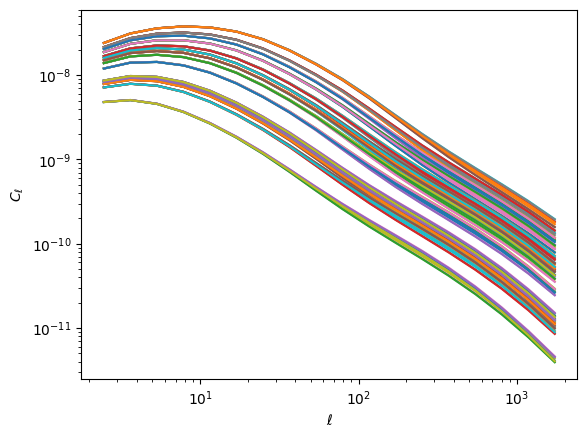

In [70]:
## TEST: Plot C_ell to see if shapes are reasonable

ell_bin_number = int(len(ell)/((len(Binned_distribution)+1)*len(Binned_distribution)/2))

for i in range(len(B_data)):
    for j in range(int(len(B_data[0])/ell_bin_number) - 1):
        plt.plot(ell[j*ell_bin_number:(j+1)*ell_bin_number], B_data[i][j*ell_bin_number:(j+1)*ell_bin_number])


plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell$')
plt.xscale('log')
plt.yscale('log')
plt.show()

Text(0, 0.5, '$\\frac{C^{00}_{NL}(\\ell)}{C^{00}_{Linear}(\\ell)} - 1$')

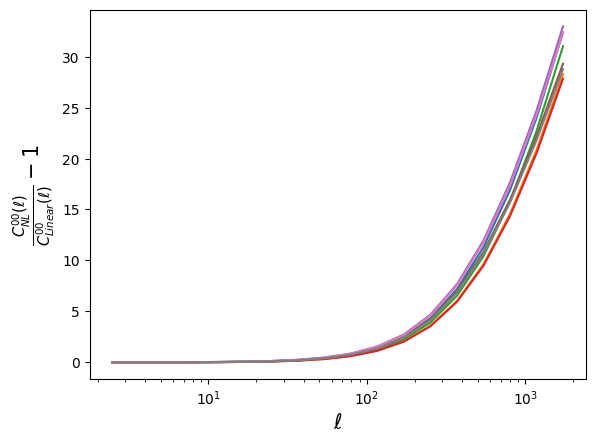

In [71]:
# TEST: Plot processed data to compare with Huang et al 2020

frac = (B_data / M_data) - 1

plt.xscale('log')
#plt.ylim(-0.1,0.5)
#plt.xlim(2,1e2)
for i in range(len(B_data)):
    plt.plot(ell[0:ell_bin_number],frac[i][0:ell_bin_number])

plt.xlabel(r'$\ell$', size = 15)
plt.ylabel(r'$\frac{C^{00}_{NL}(\ell)}{C^{00}_{Linear}(\ell)} - 1$', size = 15)

Text(0, 0.5, '$C^{00}_{NL}(\\ell) - C^{00}_{Linear}(\\ell)$')

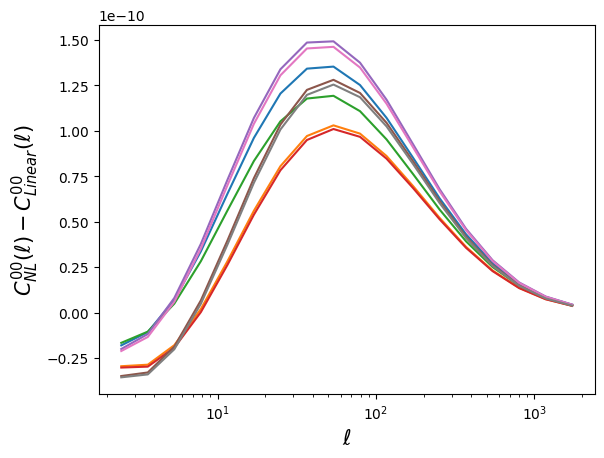

In [72]:
# TEST: Plot processed data to compare with Huang et al 2020

sub = (B_data - M_data) 

plt.xscale('log')
#plt.ylim(0,0.5)
for i in range(len(B_data)):
    plt.plot(ell[0:ell_bin_number],sub[i][0:ell_bin_number])
    
plt.xlabel(r'$\ell$', size = 15)
plt.ylabel(r'$C^{00}_{NL}(\ell) - C^{00}_{Linear}(\ell)$', size = 15)


## Finding PCA components

PCA conventions in Python

A = $\begin{bmatrix}
a00 & a01 & a02\\
a10 & a11 & a12
\end{bmatrix}$ = [[a00, a01, a02], [a10, a11, a12]], with aij = A[i][j]

A[0] is first row, A[:][0] is first column

len(A) = number of rows, len(A[0]) = number of columns

AxB = np.matmul(A,B)

for B = $\begin{bmatrix}
b00 & b01 & b02\\
b10 & b11 & b12
\end{bmatrix}$, np.append(A,B, axis = 0) = A = $\begin{bmatrix}
a00 & a01 & a02\\
a10 & a11 & a12\\
b00 & b01 & b02\\
b10 & b11 & b12
\end{bmatrix}$ 

In [ ]:
# Perform PCA with numpy.linalg.svd - find rotation matrix
def findPCA(M_data, B_data):
    Delta = (B_data - M_data)
    Usvd, s, vh = np.linalg.svd(Delta.T, full_matrices=True)
    Usvd = Usvd.T
    return Usvd

# Perform PCA with numpy.linalg.svd - find cut rotation matrix
def findPCA(M_data, B_data):
    Delta = (B_data - M_data)
    Usvd, s, vh = np.linalg.svd(Delta.T, full_matrices=True)
    Usvd = Usvd.T
    return Usvd

In [73]:
#TEST: Write out the difference matrix
Delta = (B_data - M_data)

print("Size of difference matrix Delta = ", Delta.shape)

Size of difference matrix Delta =  (8, 270)


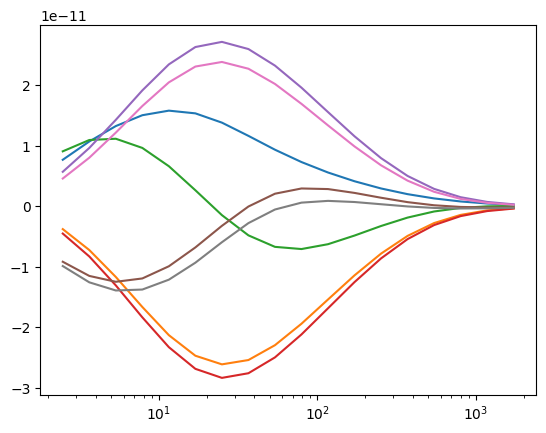

In [74]:
#TEST
Delta_centered = np.zeros((len(Delta),len(Delta[0])))
for i in range(len(Delta[0])):
    offset = np.mean(Delta.T[i])
    Delta_centered[:,i] = Delta[:,i] - offset


plt.xscale('log')
#plt.ylim(0,0.5)
for i in range(len(B_data)):
    plt.plot(ell[0:ell_bin_number],Delta_centered[i][0:ell_bin_number])

In [75]:
#TEST: Perform PCA with sklearn (Choose n_components to keep)
pca = PCA()

# Apply sklearn PCA method
sklearn_PCA = pca.fit(Delta)

# Find vectors in direction of PCs (normalized ,positive)
PCAs_vects_sklearn = sklearn_PCA.components_
print("PCA eigenvector array size = ", PCAs_vects_sklearn.shape)

# Find eigenvalues for each PC
PCAs_eigenvals_sklearn = sklearn_PCA.singular_values_

print("eigenvalues = ", PCAs_eigenvals_sklearn)
#find PC vectors with eigenvalues as norm

Usklearn = np.matmul(np.diag(PCAs_eigenvals_sklearn), np.matrix(PCAs_vects_sklearn))

print("PCA norm eigenvector array size = ",Usklearn.shape)

PCA eigenvector array size =  (8, 270)
eigenvalues =  [1.80437086e-09 6.97538788e-10 1.45891471e-11 3.08163010e-12
 1.40388762e-12 5.86340848e-13 2.85751396e-13 8.87828929e-25]
PCA norm eigenvector array size =  (8, 270)


In [1]:
#TEST: Perform PCA with numpy.linalg.svd

Usvd, s, vh = np.linalg.svd(Delta.T, full_matrices=True)

Usvd = Usvd.T

print("eigenvalues = ", s)

print("shape U = ", Usvd.shape)
print("shape sigma = ", s.shape)
print("shape V_transpose = ", vh.shape)

NameError: name 'np' is not defined

In [77]:
def findU_PCAmethod(Delta):
    
    # find eigenvectors and eigenvalues of AAt = Delta*Deltat
    AAt = np.matmul(Delta,np.transpose(Delta))
    eigenvals,eigenvects = np.linalg.eig(AAt)

    eigenvals = eigenvals.real
    eigenvects = eigenvects.real

    # Put eigenvectors and eigenvalues in right order, find U
    #composedmatrix = np.array(np.append([eigenvals],np.transpose(eigenvects), axis = 0))
    #orderedmatrix = composedmatrix[:, (-composedmatrix)[0].argsort()]
    #U = np.transpose(orderedmatrix[1:])
    return eigenvects, eigenvals

In [78]:
""" PCA decomposition"""

# Find Delta as 990 rows and 9 columns
manual_soln = findU_PCAmethod(np.transpose(Delta))
Umanual = manual_soln[0].T
eigenval_manual = manual_soln[1]
print("eigenvalues = ", eigenval_manual[:8]**0.5)


eigenvalues =  [1.09235673e-08 1.25855544e-09 8.07595393e-11 8.85851913e-12
 2.06804957e-12 1.22304832e-12 3.90129526e-13 2.85481789e-13]


In [79]:
print("full eigenvalues = ", np.abs(eigenval_manual)**0.5)

full eigenvalues =  [1.09235673e-08 1.25855544e-09 8.07595393e-11 8.85851913e-12
 2.06804957e-12 1.22304832e-12 3.90129526e-13 2.85481789e-13
 6.58586854e-17 5.05977774e-17 5.05977774e-17 4.52348763e-17
 4.52348763e-17 4.06275062e-17 4.06275062e-17 5.11076559e-17
 5.11076559e-17 4.69121569e-17 4.69121569e-17 2.89028030e-17
 2.89028030e-17 4.82057406e-17 3.24583289e-17 3.24583289e-17
 4.16695976e-17 4.16695976e-17 7.73427905e-18 7.73427905e-18
 4.41873924e-17 4.41873924e-17 3.62416676e-17 3.62416676e-17
 4.23915832e-17 4.23915832e-17 4.20451303e-17 4.11349345e-17
 4.11349345e-17 3.51106860e-17 3.51106860e-17 4.26537026e-17
 4.10923771e-17 4.10923771e-17 2.07978260e-17 2.07978260e-17
 1.34021471e-17 1.34021471e-17 2.56558930e-17 2.56558930e-17
 3.61962554e-17 3.61962554e-17 3.96935401e-17 3.55721804e-17
 3.55721804e-17 3.16153477e-17 3.16153477e-17 3.58960874e-17
 3.54622076e-17 3.54622076e-17 3.02111281e-17 3.02111281e-17
 3.30246141e-17 3.30246141e-17 3.40262654e-17 1.97175782e-17
 1.9

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


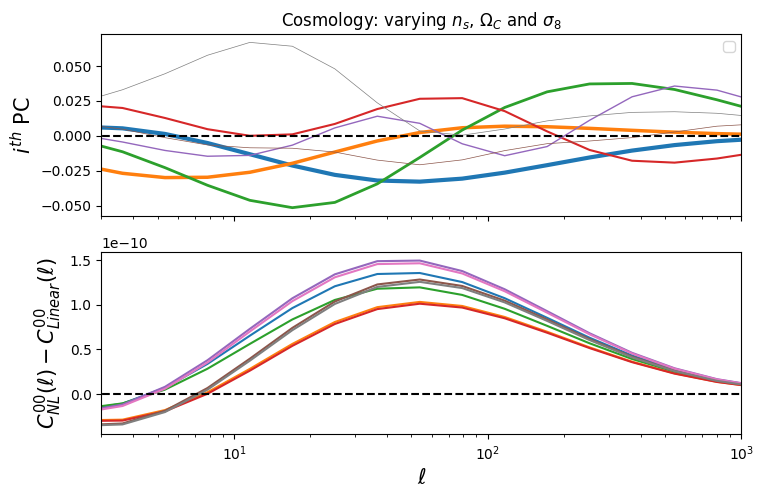

In [80]:
"""Plot PCA components for different methods as a function of ell, and compare with angular power spectra"""

f, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=False,figsize=(8, 5))

for i in range(8):
    #ax1.plot(ell[0:ell_bin_num], Umanual[i][0:ell_bin_num], color = "b", label = "Manual method")
    ax1.plot(ell[0:ell_bin_number], -Usvd[i][0: ell_bin_number], linewidth=3 - 0.5*i)
    #ax1.plot(ell[0:ell_bin_num], Usklearn[i,0:ell_bin_num], label = "sklearn method", color = "y")
    #ax1.plot(ell[0:ell_bin_number], PCAs_vects_sklearn[i,0:ell_bin_number], color = "y",linewidth=2+i/2)
    
ax1.plot(ell[0:ell_bin_number], np.zeros(len(ell[0:ell_bin_number])), "k--")

#line2, = ax1.plot(ell[0:ell_bin_number], PCAs_vects_sklearn[0,0:ell_bin_number], label = "centered around zero", color = "y")
#line1, = ax1.plot(ell[0:ell_bin_number], -Usvd[0][0: ell_bin_number], color = "r" , label = "not centered", linewidth=2)
ax1.legend()

#line1.remove()
#line2.remove()

ax1.set_ylabel(r'$i^{th}$ PC', size = 15)
ax1.set_title("Cosmology: varying $n_s$, $\Omega_C$ and $\sigma_8$")
plt.xscale("log")


#plt.ylim(0,0.5)
for i in range(len(B_data)):
    ax2.plot(ell[0:ell_bin_number],Delta[i][0:ell_bin_number])
ax2.plot(ell[0:ell_bin_number], np.zeros(len(ell[0:ell_bin_number])), "k--")

ax2.set_ylabel(r'$C^{00}_{NL}(\ell) - C^{00}_{Linear}(\ell)$', size = 15)
ax2.set_xlabel(r'$\ell$', size = 15)

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.2)
ax1.set_xlim(3,1e3)


#plt.savefig('PCcompare.pdf' , bbox_inches='tight')
plt.show()

